# Computational -- HW 3 -- Mahan Mirza Khanlari

# 1

# Code Explanation

This code compares two methods for computing gravitational accelerations (with G = 1) for a set of unit-mass particles in 3D. Each particle’s position is generated uniformly in the range [0, 100] in each dimension with a fixed seed.

The goal is to compute the gravitational acceleration on each particle due to all the others, using:

$$
\mathbf{a}_i = -\sum_{j \ne i} \frac{\mathbf{r}_j - \mathbf{r}_i}{|\mathbf{r}_j - \mathbf{r}_i|^3}
$$

Two approaches are implemented:
1. A direct pairwise summation (with memory-efficient chunking).
2. An approximate Barnes-Hut method using an oct-tree.

I also attempted to use SciPy’s KDTree, but it only worked when ignoring particles beyond a cutoff radius, which resulted in huge relative errors. I couldn’t figure out how to traverse a KDTree for an approximate far-field computation using a center-of-mass (COM) approach. This Barnes-Hut method was GPT's suggestion but the description of this method matches exactly with Springel's March 11 notes Slide 40 which says: "Idea: Group distant particles together, and use their multipole expansion." So I implemented this method.

---

### `generate_positions`

Simple, it sets the random seed and generates an array of shape (N,3) with uniformly distributed particle positions.

### `direct_acceleration_chunked`

Calculates accelerations by summing the gravitational contributions from every other particle. To reduce memory issues, I chunked the computation. For each chunk, it extracts the x,y,z components, creates full arrays for pairwise differences, and avoids self-interactions by setting the diagonal to infinity. 

### `OctreeNode`

This class represents a cell in the oct-tree. Each node stores the indices of the particles it contains, the cell’s geometric center, its half side-length, a flag indicating whether it is a leaf (unsplit), the total mass (simply the particle count, since each particle has unit mass), and the center-of-mass of its particles. When an instance is created, the node calls `build`, which computes the mass and center-of-mass. If more than one particle is present, the cell is subdivided into 8 octants by comparing each particle’s coordinates to the cell’s center using a bitwise code, and then recursively creating child nodes for each non-empty octant.

### `compute_acceleration_for_particle`

This recursive function computes the gravitational acceleration on a specific particle by traversing the oct-tree. It calculates the vector

$$
\mathbf{r}_{\text{vec}} = \mathbf{r}_{\text{COM}} - \mathbf{r}
$$

and its magnitude $d$. An opening criteria is then applied: if the node’s effective size (2 x half\_size) divided by $d$ is less than a threshold $\theta$, or if the node is a leaf, the node is considered “far” and its entire mass is approximated as being concentrated at the center-of-mass. Otherwise, the function recurses into the node’s children for a more detailed calculation. 

### `compute_all_accelerations`

Builds the Barnes-Hut tree and computes the acceleration on every particle. It starts by creating the root node, which represents the entire box, then calls `compute_acceleration_for_particle` for each particle using the constructed tree. The resulting array of accelerations is computed with the COM approximation.

### Main Driver

The main block runs the simulation for different particle counts (10^3, 10^4, and 10^5). For each N, it generates particle positions, computes accelerations using both the direct and Barnes-Hut methods, times each method, and calculates the mean relative error between them. 

---

### A summary on tree construction

- The tree is built recursively until each leaf node contains at most one particle.
- The computation begins at the root node, which represents the entire box divided into 8 octants.
- For each node, the distance $d$ from a particle to the node's center-of-mass is computed.
- The opening criteria is applied: if

$$
\frac{2 \times \text{half\_size}}{d} < \theta,
$$

The node is considered "far" and its aggregated center-of-mass is used to approximate the gravitational force. If the node is too "close", the algorithm recursively examines its children for a more accurate calculation.

---

### Note on Performance

When testing with \(10^6\) particles, the direct method failed due to memory issues. Even with chunking, the following part of the code remained too memory intensive:

```python
N = len(positions)
x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]
acc = np.zeros_like(positions)
full_x = x[None, :]
full_y = y[None, :]
full_z = z[None, :]
```

In [1]:
import numpy as np
import time
from tqdm import tqdm

In [2]:
#Generate positions in 3D
def generate_positions(N, L, seed):
    np.random.seed(seed)
    return np.random.uniform(0, L, (N, 3)).astype(np.float32)

In [3]:
#Direct acceleration calculation
def direct_acceleration_chunked(positions, chunk_size):
    N = len(positions)
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    acc = np.zeros_like(positions)
    full_x = x[None, :]
    full_y = y[None, :]
    full_z = z[None, :]
    
    num_chunks = (N + chunk_size - 1) // chunk_size
    for i in tqdm(range(num_chunks), desc="Computing direct accelerations", unit="chunk"):
        start = i * chunk_size
        end = min(start + chunk_size, N)
        cx = x[start:end, None]
        cy = y[start:end, None]
        cz = z[start:end, None]
        dx = cx - full_x
        dy = cy - full_y
        dz = cz - full_z
        dist_sq = dx**2 + dy**2 + dz**2

        np.fill_diagonal(dist_sq[:, start:end], np.inf)
        inv_dist_cube = 1.0 / (dist_sq * np.sqrt(dist_sq))
        
        ax_chunk = np.sum(dx * inv_dist_cube, axis=1)
        ay_chunk = np.sum(dy * inv_dist_cube, axis=1)
        az_chunk = np.sum(dz * inv_dist_cube, axis=1)
        
        acc[start:end, 0] = ax_chunk
        acc[start:end, 1] = ay_chunk
        acc[start:end, 2] = az_chunk
    return acc

In [4]:
#Octree class
class OctreeNode:
    def __init__(self, indices, center, half_size, positions):
        self.indices = indices     
        self.center = center       
        self.half_size = half_size    
        self.children = [None] * 8   
        self.is_leaf = True
        self.mass = 0
        self.center_of_mass = np.zeros(3)
        self.build(positions)
        
    def build(self, positions):
        n_particles = len(self.indices)
        if n_particles == 0:
            self.mass = 0
            self.center_of_mass = np.zeros(3)
            return

        self.mass = n_particles
        self.center_of_mass = np.mean(positions[self.indices], axis=0)

        if n_particles > 1:
            self.is_leaf = False
            new_half_size = self.half_size / 2.0
            children_indices = [[] for _ in range(8)]
            for idx in self.indices:
                pos = positions[idx]
                code = 0
                if pos[0] >= self.center[0]:
                    code |= 1
                if pos[1] >= self.center[1]:
                    code |= 2
                if pos[2] >= self.center[2]:
                    code |= 4
                children_indices[code].append(idx)

            for i in range(8):
                if len(children_indices[i]) > 0:
                    direction = np.array([1 if (i & (1 << d)) else -1 for d in range(3)], dtype=float)
                    child_center = self.center + direction * new_half_size
                    self.children[i] = OctreeNode(children_indices[i], child_center, new_half_size, positions)

In [5]:
#Recursive function to compute gravitational acceleration
def compute_acceleration_for_particle(i, pos, node, theta, positions):
    r_vec = node.center_of_mass - pos
    d = np.linalg.norm(r_vec)

    if d == 0:
        if len(node.indices) == 1 and node.indices[0] == i:
            return np.zeros(3)
        else:
            d = 1e-10

    if node.is_leaf or (2 * node.half_size) / d < theta:
        if len(node.indices) == 1 and node.indices[0] == i:
            return np.zeros(3)
        return -node.mass * r_vec / (d**3)
    else:
        acc = np.zeros(3)
        for child in node.children:
            if child is not None and child.mass > 0:
                acc += compute_acceleration_for_particle(i, pos, child, theta, positions)
        return acc

In [6]:
#Compute accelerations for all particles(Oct tree)
def compute_all_accelerations(positions, theta):
    N = len(positions)
    L = np.max(positions)
    root_center = np.array([L/2, L/2, L/2])
    root_half_size = L/2
    indices = list(range(N))
    tree = OctreeNode(indices, root_center, root_half_size, positions)
    
    accelerations = np.zeros_like(positions)
    for i in range(N):
        accelerations[i] = compute_acceleration_for_particle(i, positions[i], tree, theta, positions)
    return accelerations

In [9]:
#Running the simulation
if __name__ == "__main__":
    N_values = [10**3, 10**4, 10**5]
    L = 100.0
    seed = 42
    theta = 0.8 #I tried with different values, 0.8 was a good balance between accuracy and speed  
    chunk_size = 500   
    
    for N in N_values:
        print(f"\nN = {N:,}")
        positions = generate_positions(N, L, seed)

        start = time.perf_counter()
        acc_direct = direct_acceleration_chunked(positions, chunk_size)
        end = time.perf_counter()
        dt_direct = end - start
        print(f"Direct method time: {dt_direct:.3f} seconds")

        start = time.perf_counter()
        acc_bh = compute_all_accelerations(positions, theta)
        end = time.perf_counter()
        dt_bh = end - start
        print(f"Barnes-Hut method time: {dt_bh:.3f} seconds")
        
        #Mean relative error between the methods
        relative_errors = np.linalg.norm(acc_direct - acc_bh, axis=1) / np.linalg.norm(acc_direct, axis=1)
        mean_relative_error = np.mean(relative_errors)
        print("Mean Relative Error: {:.3f}%".format(mean_relative_error * 100))


N = 1,000


Computing direct accelerations: 100%|██████████| 2/2 [00:00<00:00, 99.21chunk/s]

Direct method time: 0.025 seconds


Barnes-Hut method time: 1.209 seconds
Mean Relative Error: 2.277%

N = 10,000


Computing direct accelerations: 100%|██████████| 20/20 [00:01<00:00, 13.13chunk/s]


Direct method time: 1.531 seconds
Barnes-Hut method time: 19.921 seconds
Mean Relative Error: 1.240%

N = 100,000


Computing direct accelerations: 100%|██████████| 200/200 [04:10<00:00,  1.25s/chunk]


Direct method time: 250.827 seconds
Barnes-Hut method time: 294.755 seconds
Mean Relative Error: 0.711%


 ## Time Scaling Behavior

The direct method exhibits a ~ (N^2) scaling. This quadratic cost quickly becomes prohibitive as  N increases (as mentioned above, but it's not only memory, it's also cpmputational time).

In contrast, the Barnes-Hut method based on the oct-tree approximation has a theoretical scale of ~ NlogN. The actual performance is affected by overheads such as tree construction, recursive traversal, etc. But the scaling still wayy better than the direct method (See the N=10K to N=100K scaling for both methods above.)

I'd choose direct for up to N=10^5 only. You can see that direct method for 10^6 (if not memory issues) would be ~ 24,000 seconds (with N^2) if extrapolated. But the Oct tree is ~4,000. And for 10^7 it's not even comparible at that point.

# 2

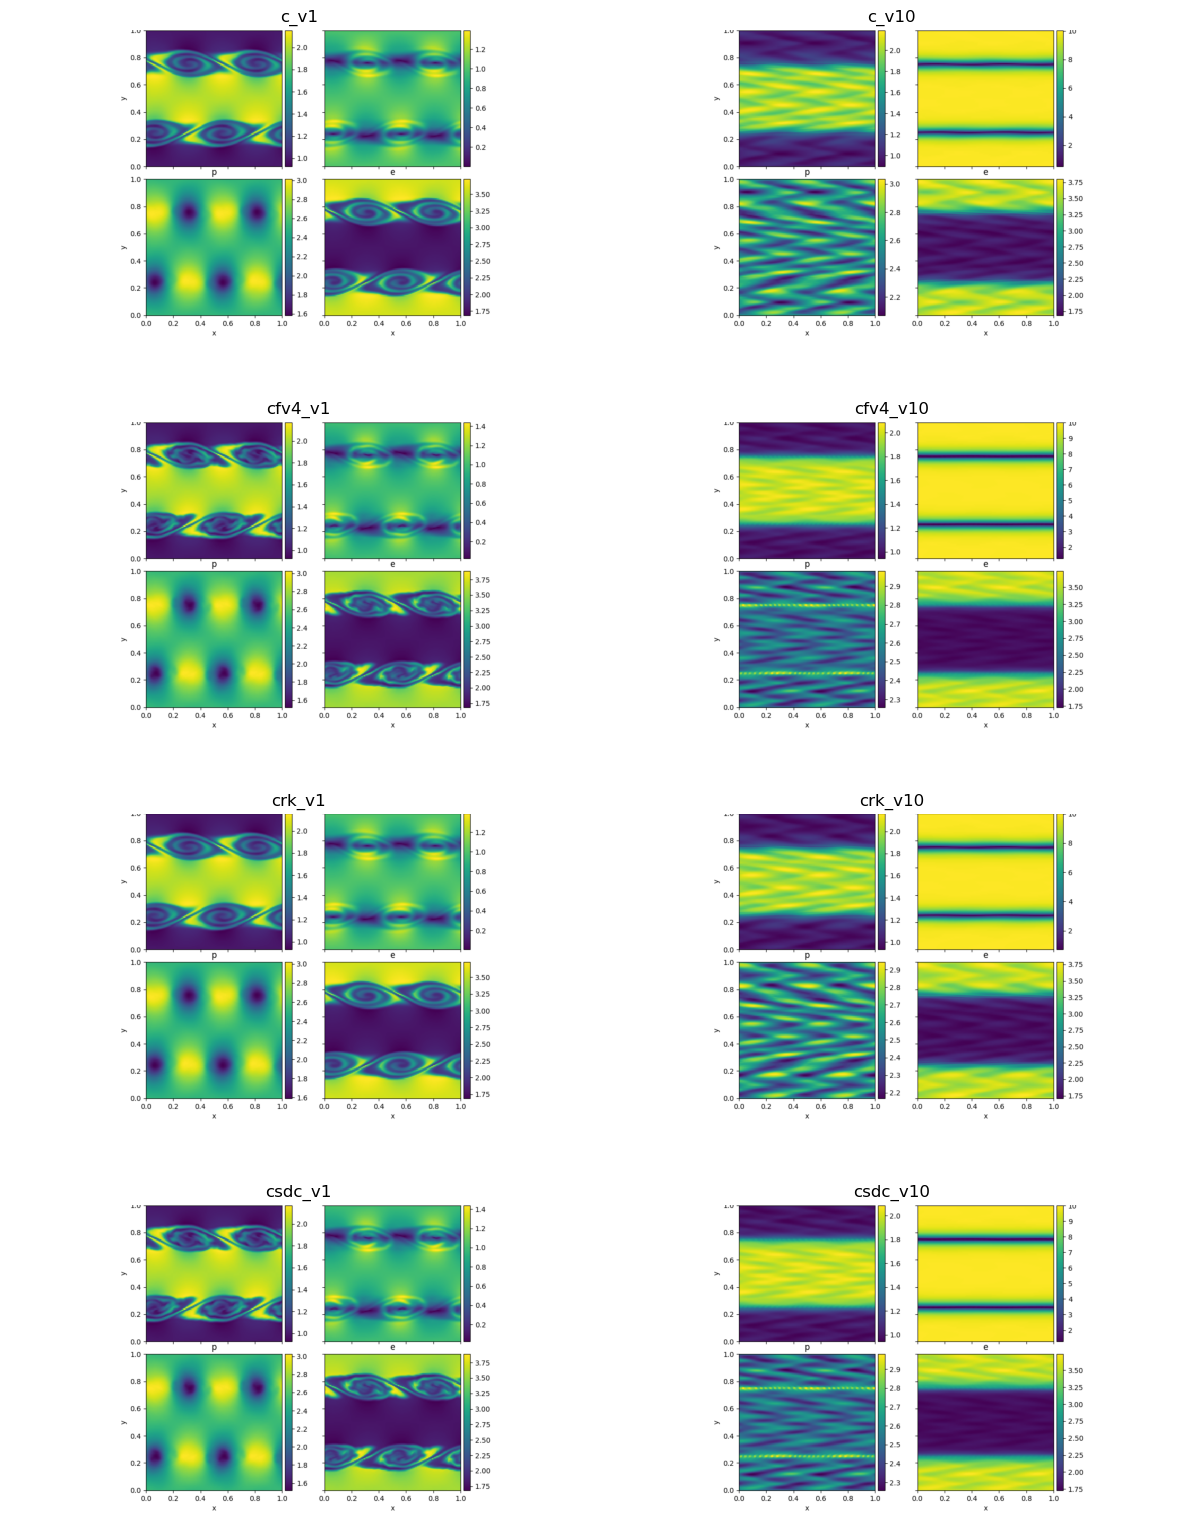

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
files = [
    'c_v1.png', 'c_v10.png', 'cfv4_v1.png', 'cfv4_v10.png',
    'crk_v1.png', 'crk_v10.png', 'csdc_v1.png', 'csdc_v10.png'
]
path = '/home/jovyan/work/stampede3/Kelvin_Helmholtz_plots/'
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for ax, file in zip(axes.flat, files):
    img = mpimg.imread(path + file)
    h, w = img.shape[:2]
    dh = int(h * 0.15)
    dw = int(w * 0.1)
    zoomed_img = img[dh:h-dh, dw:w-dw]
    ax.imshow(zoomed_img)
    ax.axis('off')
    ax.set_title(file.replace('.png', ''), fontsize=12)
plt.tight_layout()
plt.show()

When I ran the KH problem with a relative velocity of +-1, I get exactly what KH looks like; well-behaved vortices forming at the shear interface. The instability grows steadily and the fluid rolls up into  swirls.

But when I go to the relative velocity +-10 things change and I end up with messy, jagged features. It looks more like turbulence or shock-dominated flow. The interface never really gets the chance to develop the instability I guess.

So in short: low velocity gives you textbook KH instability. High velocity breaks that picture—too much shear, too fast, and you lose the nice featues. I'm not sure if we need to show the origin with math and equations or not.

Also the bulk velocity in all of them were 0 and gamma is 1.7 and it's a 128x128 cell. I ran everything in the temrinal, just a heads up that the guide is wrong about two things:
1. pyro.py is actually pyro_sim.py,
2. inputs.kh should have kh.bulk_velocity not kh.vbulk